In [1]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import f1_score, accuracy_score

from keras.datasets import mnist

import matplotlib.pyplot as plt

import warnings
from datetime import datetime

# suppress warnings
warnings.filterwarnings("ignore")

%matplotlib inline

2023-03-23 10:29:56.755711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [2]:
def lire_alpha_digit(chars):
    alpha_digits = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)


def lire_mnist(subsample_size=-1):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # subsample to 1000 samples
    if subsample_size != -1:
        X_train = X_train[:subsample_size]
        y_train = y_train[:subsample_size]
        X_test = X_test[:subsample_size]
        y_test = y_test[:subsample_size]

    # to binary and flatten
    X_train_bin = (X_train >= 128).astype(int).reshape(X_train.shape[0], -1)
    X_test_bin = (X_test >= 128).astype(int).reshape(X_test.shape[0], -1)

    # one hot encode
    y_train = one_hot_encode(y_train)
    y_test = one_hot_encode(y_test)
    return X_train_bin, X_test_bin, y_train, y_test

# Utils

In [3]:
def one_hot_encode(y):
    unique_labels = np.unique(y)
    y_ohe = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(y.shape[0]):
        y_ohe[i, np.where(unique_labels == y[i])] = 1
    return y_ohe


def idx2char(idx):
    if 0 <= idx <= 9:
        return chr(idx + 48)
    else:
        return chr(idx + 55)

# Plot utils

In [4]:
def plot_data(X, y=None, save=False):
    perm = np.random.permutation(X.shape[0])
    plt.figure()
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[perm[i]], cmap="gray")
        if y is not None:
            plt.xlabel(idx2char(y[perm[i]]))
    plt.tight_layout()
    if save:
        now = datetime.now()
        dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
        plt.savefig(f"data_{dt_string}")
    plt.show()

# Functions

In [5]:
def softmax(x):
    """
    Calcule la fonction softmax.
    """
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T


def sigmoid(x):
    """
    Calcule la fonction sigmoïde.
    """
    return 1 / (1 + np.exp(-x))


def calcul_softmax(layer, X):
    """
    Calcule les probabilités sur les unités de sortie à partir de la fonction softmax. Cette fonction retournera les probabilités sur les unités de sortie et prendra en argument un RBM et des données d'entrée.
    """
    return softmax(np.dot(X, layer.W) + layer.b)

# RBM

In [6]:
class RBM:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.01, (p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)


def init_RBM(p, q):
    """
    Construit et initialise les poids et les biais d'un RBM. Cette fonction retournera une structure RBM avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    rbm = RBM(p, q)
    return rbm


def entree_sortie_RBM(rbm, X):
    """
    Calcule la valeur des unités de sortie d'un RBM à partir des données d'entrée et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(X, rbm.W) + rbm.b)


def sortie_entree_RBM(rbm, H):
    """
    Calcule la valeur des unités d'entrée d'un RBM à partir des données de sortie et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(H, rbm.W.T) + rbm.a)


def train_RBM(rbm, X, epochs, learning_rate, batch_size):
    """
    Apprend un RBM par l'algorithme Contrastive-Divergence-1. Cette fonction retournera un structure
    RBM et prendra en argument une structure RBM, le nombre d'itérations de la descente de gradient (epochs),
    le learning rate, la taille du mini-batch, des données d'entrées...
    """
    n = X.shape[0]
    p, q = rbm.W.shape
    for epoch in range(epochs):
        X_copy = np.copy(X)
        np.random.shuffle(X_copy)
        for i in range(0, n, batch_size):
            v_0 = X[i : i + batch_size]
            tb = len(v_0)
            es_v_0 = entree_sortie_RBM(rbm, v_0)
            h_0 = (np.random.uniform(size=(tb, q)) < es_v_0).astype("float")
            v_1 = (
                np.random.uniform(size=(tb, p)) < sortie_entree_RBM(rbm, h_0)
            ).astype("float")
            h_1 = entree_sortie_RBM(rbm, v_1)
            rbm.W += learning_rate / tb * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
            rbm.a += learning_rate / tb * np.sum(v_0 - v_1, axis=0)
            rbm.b += learning_rate / tb * np.sum(es_v_0 - h_1, axis=0)
    return rbm


def generer_image_RBM(rbm, n_iter, n_image):
    """
    Génère des échantillons suivant un RBM. Cette fonction retournera et affichera les images générées et prendra en argument une structure de type RBM, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    p, q = rbm.W.shape
    X = (np.random.uniform(size=(n_image, p)) < 0.5).astype("float")
    for i in range(n_iter):
        H = (np.random.uniform(size=(n_image, q)) < entree_sortie_RBM(rbm, X)).astype(
            "float"
        )
        X = (np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(rbm, H)).astype(
            "float"
        )
    return X

# DBN

In [7]:
class DBN:
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 1):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))

    def __len__(self):
        return len(self.layers)

    def __getitem__(self, i):
        return self.layers[i]

    def __setitem__(self, i, layer):
        self.layers[i] = layer


def init_DBN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DBN. Cette fonction retournera un DBN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dbn = DBN(n_layers)
    return dbn


def train_DBN(dbn, X_init, epochs, learning_rate, batch_size):
    """
    Apprend un DBN par la méthode Greedy Layer-Wise. Cette fonction retournera un DBN pré-entrainé et prendra en argument un DBN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    X = X_init
    for rbm in dbn:
        rbm = train_RBM(rbm, X, epochs, learning_rate, batch_size)
        X = entree_sortie_RBM(rbm, X)
    return dbn


def generer_image_DBN(dbn, n_iter, n_image):
    """
    Génère des échantillons suivant un DBN. Cette fonction retournera et affichera les images générées et prendra en argument un DBN pré-entrainé, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    X = generer_image_RBM(dbn[-1], n_iter, n_image)
    for i in range(len(dbn) - 2, -1, -1):
        p, q = dbn[i].W.shape
        X = (
            np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(dbn[i], X)
        ).astype("float")
    return X

# DNN

In [8]:
class FC:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.1, (p, q))
        self.b = np.zeros(q)


class DNN(DBN):
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 2):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))
        self.layers.append(FC(n_layers[-2], n_layers[-1]))


def init_DNN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DNN. Cette fonction retournera un DNN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dnn = DNN(n_layers)
    return dnn


def pretrain_DNN(dnn, X_init, epochs, lr, batch_size):
    """
    Pré-entraine un DNN. Cette fonction retournera un DNN pré-entrainé et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    for epoch in range(epochs):
        X = X_init
        for rbm in dnn[:-1]:
            rbm = train_RBM(rbm, X, epochs, lr, batch_size)
            X = entree_sortie_RBM(rbm, X)
    return dnn


def entree_sortie_reseau(dnn, X):
    """
    Calcule les sorties sur chaque couche du réseau (couche d'entrée inclue) ainsi que les probabilités sur les unités de sortie. Cette fonction retournera une liste contenant les sorties sur chaque couche du réseau ainsi que les probabilités sur les unités de sortie et prendra en argument un DNN et des données d'entrée.
    """
    sorties = [X]
    for rbm in dnn[:-1]:
        sorties.append(entree_sortie_RBM(rbm, sorties[-1]))
    sorties.append(calcul_softmax(dnn[-1], sorties[-1]))
    return sorties


def retropropagation(dnn, X, y, epochs, lr, batch_size, verbose):
    """
    Estime les poids/biais du réseau à partir de données labellisées. Cette fonction retournera un DNN et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrée, leur label,...
    """
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            tb = len(X_batch)
            sortie = entree_sortie_reseau(
                dnn,
                X_batch,
            )
            # compute dL/dZ
            d_Z = sortie[-1] - y_batch

            for j in range(len(dnn) - 1, -1, -1):
                grad_W = 1 / tb * np.dot(sortie[j].T, d_Z)
                grad_b = 1 / tb * np.sum(d_Z, axis=0)

                # update W and b
                dnn.layers[j].W -= learning_rate * grad_W
                dnn.layers[j].b -= learning_rate * grad_b

                if j == 0:  # no need to compute at last iteration
                    break

                # compute dL/dA and dL/dZ
                d_A = np.dot(d_Z, dnn[j].W.T)
                d_Z = d_A * sortie[j] * (1 - sortie[j])
            cross_entropy = -np.mean(np.sum(y_batch * np.log(sortie[-1]), axis=1))
        if verbose == 2:
            print(f"Epoch {epoch} - CE:", cross_entropy)
    return dnn


def test_DNN(dnn, X, y):
    """
    Teste les performances du réseau appris. Cette fonction retournera le taux d'erreur et prendra en argument un DNN appris, un jeu de données test, et les vrais labels associés.
    """
    sortie = entree_sortie_reseau(dnn, X)
    # Compute cross entropy
    cross_entropy = -np.mean(np.sum(y * np.log(sortie[-1]), axis=1))
    return sortie[-1], cross_entropy

# Run

In [9]:
def run_RBM(
    X,
    width: int,
    height: int,
    q: int,
    epochs: int,
    learning_rate,
    batch_size: int,
):

    rbm = init_RBM(p=width * height, q=q)

    train_RBM(rbm, X, epochs, learning_rate, batch_size)

    X_gen = generer_image_RBM(rbm, 100, 9).reshape(-1, width, height)
    return X_gen

In [10]:
def run_DBN(
    X,
    n_layers,
    width: int,
    height: int,
    epochs: int,
    learning_rate,
    batch_size: int,
):
    dbn = init_DBN(n_layers)

    train_DBN(dbn, X, epochs, learning_rate, batch_size)

    X_gen = generer_image_DBN(dbn, 100, 9).reshape(-1, width, height)
    return X_gen

In [11]:
def run_DNN(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers,
    learning_rate,
    batch_size,
    pretrain_iter,
    train_iter,
    verbose=1,
):
    # Initialisation du DNN
    dnn = init_DNN(n_layers)

    # Pré-entrainement du DNN
    if pretrain_iter:
        dnn = pretrain_DNN(dnn, X_train, pretrain_iter, learning_rate, batch_size)

    # Entrainement du DNN
    dnn = retropropagation(
        dnn, X_train, y_train, train_iter, learning_rate, batch_size, verbose
    )

    # Test du DNN
    y_pred, cross_entropy = test_DNN(dnn, X_test, y_test)
    score = f1_score(
        np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro"
    )
    if verbose >= 1:
        print("f1_score", score)

    return cross_entropy, score

# Etude sur Binary AlphaDigit

In [12]:
all = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]

X, y = lire_alpha_digit(chars=all)
height = 20
width = 16

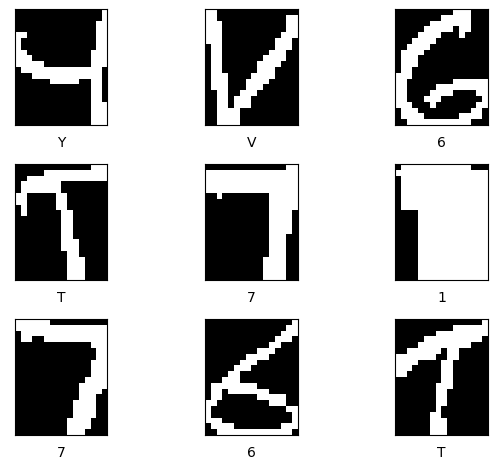

In [13]:
plot_data(X.reshape(-1, height, width), y, save=True)

In [14]:
small = ["2", "3", "4"]
medium = [str(i) for i in range(10)]
large = [chr(i) for i in range(65, 91)]

print("Small:", small)
print("Medium:", medium)
print("Large:", large)

Small: ['2', '3', '4']
Medium: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Large: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


--- Size: small ---
RBM


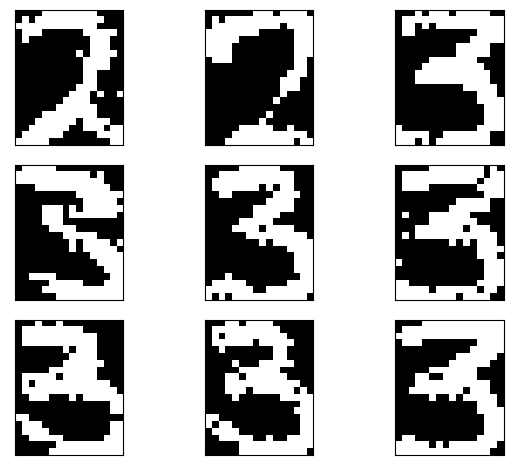

DBN


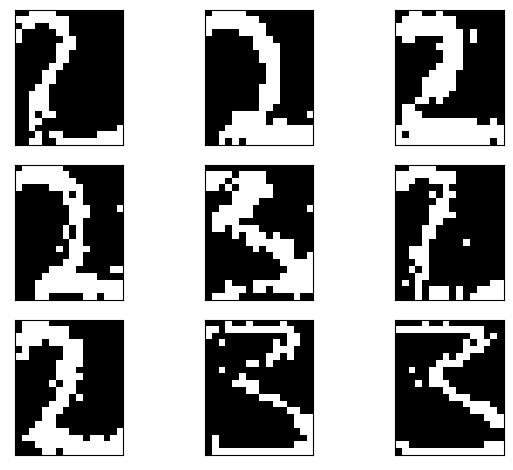

--- Size: medium ---
RBM


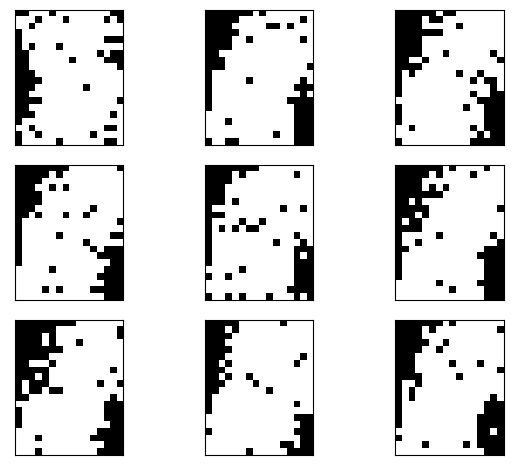

DBN


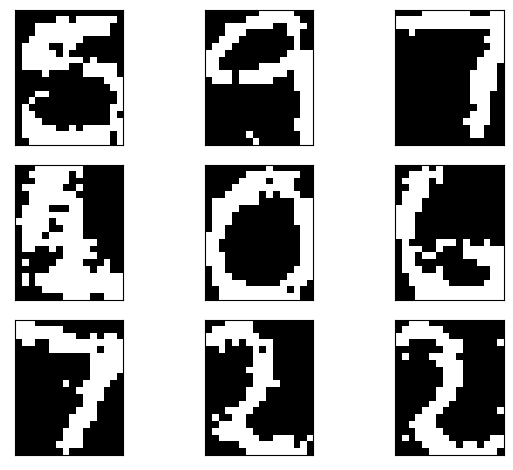

--- Size: large ---
RBM


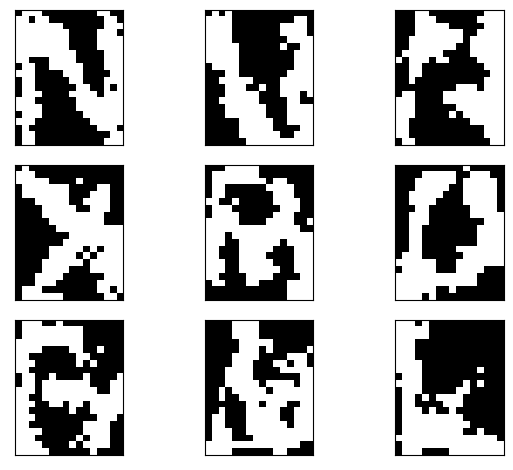

DBN


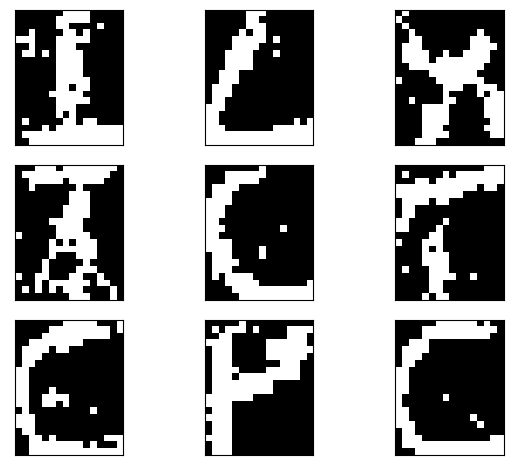

In [15]:
epochs = 100
learning_rate = 0.1
batch_size = 10
q = 200
n_layers = [320, 200, 200]

for size, chars in zip(["small", "medium", "large"], [small, medium, large]):
    print("--- Size:", size, "---")
    X, y = lire_alpha_digit(chars=chars)

    print("RBM")

    X_gen = run_RBM(
        X,
        height,
        width,
        q,
        epochs,
        learning_rate,
        batch_size,
    )

    plot_data(X_gen, save=True)

    print("DBN")

    X_gen = run_DBN(
        X,
        n_layers,
        height,
        width,
        epochs,
        learning_rate,
        batch_size,
    )

    plot_data(X_gen, save=True)

# Etude sur MNIST

In [16]:
X_train, X_test, y_train, y_test = lire_mnist(subsample_size=-1)

batch_size = 2000
learning_rate = 0.1
n_layers = [784, 200, 10]
pretrain_iter = 5
train_iter = 5

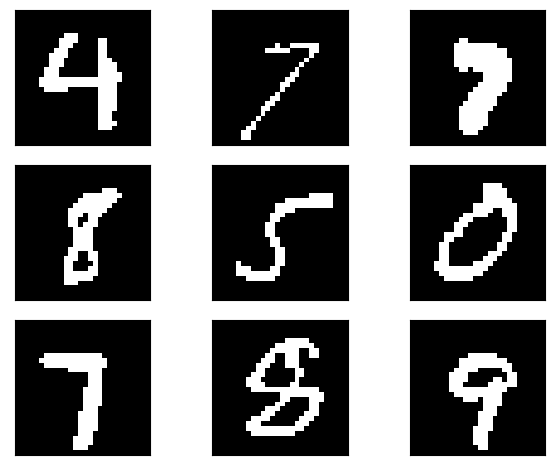

In [17]:
plot_data(X_train.reshape(-1, 28, 28))

In [18]:
ce, score = run_DNN(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=n_layers,
    learning_rate=learning_rate,
    batch_size=batch_size,
    pretrain_iter=pretrain_iter,
    train_iter=train_iter,
    verbose=1,
)

f1_score 0.8825
